# Notebook 3: Análisis de frecuencias de la señal de EEG

**Materias relacionadas:** Algoritmos Computacionales, Morfofuncional II, Matemáticas Avanzadas de la Física, Electrofisiología, Instrumentación Biomédica, Electrofisiología, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.

**Antecedentes:** Notebook 1 y Notebook 2

**Objetivos:** Conocer los algoritmos de análisis de Fourier y aplicarlos para mostrar la actividad eléctrica en distintas bandas de frecuencia de un electroencefalograma. 

## Introducción

En los notebooks anteriores hemos progresado desde la visualización cruda de señales EEG hasta su filtrado para obtener datos fisiológicamente interpretables. Como mencionamos al final del Notebook 2: "con señales apropiadamente filtradas, es necesario usar FFT y PSD para trabajar con la señal.

El análisis espectral de señales EEG es fundamental para comprender los patrones de actividad cerebral y sus correlatos funcionales (Hari & Puce, 2017). Las técnicas que implementaremos nos permitirán identificar y cuantificar las diferentes bandas de frecuencia que caracterizan los estados cognitivos, particularmente las ondas alfa durante el protocolo de ojos abiertos versus ojos cerrados.

La importancia del formato de datos en este análisis es relevante para la flexibilidad computacional. Trabajamos con archivos CSV que, como señalan Mitlöhner et al. (2016), presentan características específicas que requieren consideraciones especiales en su procesamiento, especialmente en aplicaciones biomédicas donde la integridad de datos es crítica.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftshift
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter
from scipy.integrate import simpson  # Usando la regla de Simpson para calcular el área bajo la curva

In [2]:
# Cargar datos y aplicar filtrado (heredado del Notebook 2)
carpeta = os.abspath('/Users/yann/Documents/Tesis/Datos/EEG/')
datos = pd.read_csv(carpeta + '/H24_OC_OA.csv')

# Parámetros establecidos en notebooks anteriores
fm = 128  # frecuencia de muestreo
ti, tf = 0, 180  # tiempo total de registro
pt = (tf - ti) * fm
t1, t2 = ti * fm, tf * fm
nombres = list(datos)
t = np.linspace(ti, tf, pt)

print(f"Datos cargados:")
print(f"Forma del dataset: {datos.shape}")
print(f"Canales EEG: {nombres}")
print(f"Frecuencia de muestreo: {fm} Hz")
print(f"Duración total: {tf-ti} segundos")

Datos cargados:
Forma del dataset: (23127, 14)
Canales EEG: ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
Frecuencia de muestreo: 128 Hz
Duración total: 180 segundos


In [3]:
# Aplicar filtrado pasabandas (2-45 Hz) como en Notebook 2
filtg = []
for i in range(0, 14):
    al = np.array(datos)[t1:t2, i]
    nyq = 128 * 0.5
    low = 2 / nyq
    high = 45 / nyq
    b, a = butter(3, [low, high], btype='band')
    env = filtfilt(b, a, al)
    filtg.append(env)

tmp = pd.DataFrame(filtg, nombres)
datosfilt = tmp.transpose()

print("Filtrado pasabandas (2-45 Hz) aplicado exitosamente")
print(f"Forma de datos filtrados: {datosfilt.shape}")

Filtrado pasabandas (2-45 Hz) aplicado exitosamente
Forma de datos filtrados: (23040, 14)


## 3.1 Fundamentos teóricos de la transformada de Fourier

### 3.1.1 Transformada de Fourier: conceptos fundamentales

La transformada de Fourier es una herramienta matemática fundamental que permite descomponer una señal temporal en sus componentes frecuenciales (Rader, 2017). Para señales biomédicas como el EEG, esta descomposición revela la distribución de potencia espectral a través de diferentes bandas de frecuencia, cada una asociada con procesos neurofisiológicos específicos.

Matemáticamente, la transformada de Fourier continua de una función f(t) se define como:

$$F(\omega) = \int_{-\infty}^{\infty} f(t)e^{-i\omega t}dt$$

Para señales discretas muestreadas digitalmente, utilizamos la Transformada Discreta de Fourier (DFT), cuya implementación eficiente es la FFT (Baranowski et al., 2017).

### 3.1.2 Aplicación en electroencefalografía

En el contexto del EEG, la transformada de Fourier nos permite:

1. **Identificación de bandas de frecuencia**: Cuantificar la potencia espectral en las bandas delta (1-4 Hz), theta (4-8 Hz), alfa (8-13 Hz), beta (13-30 Hz) y gamma (>30 Hz) (Olejniczak, 2006).

2. **Análisis de estados cognitivos**: Las diferentes bandas se asocian con estados específicos de conciencia y actividad cerebral (Hari & Puce, 2017).

3. **Detección de patrones patológicos**: Alteraciones en el espectro de frecuencias pueden indicar condiciones neurológicas (Ramos-Argüelles et al., 2009).

### 3.1.3 Fast Fourier Transform (FFT): implementación computacional

La FFT es un algoritmo eficiente para calcular la DFT, reduciendo la complejidad computacional de O(N²) a O(N log N) (Widmann et al., 2015). Para una señal discreta $x[n]$ de $N$ puntos, la DFT se define como:

$$X[k] = \sum_{n=0}^{N-1} x[n]e^{-i2\pi kn/N}$$

donde $k$ representa los *bins* de frecuencia y la frecuencia correspondiente es $f_k = k \cdot f_s/N$.

**Consideraciones para EEG:**
- La resolución frecuencial está determinada por $\Delta f = f_s/N$, donde $f_s$ es la frecuencia de muestreo.
- Para nuestros datos: $\Delta f = 128 \text{ Hz} / N \text{ puntos}$.
- La frecuencia de Nyquist ($f_s/2 = 64 \text{ Hz}$) determina el límite superior del análisis espectral.
- El espectro resultante es simétrico, por lo que típicamente analizamos solo la primera mitad (0 a $f_s/2$).

**Consideraciones para EEG:**
- La resolución frecuencial está determinada por Δf = f_s/N, donde f_s es la frecuencia de muestreo
- Para nuestros datos: Δf = 128 Hz / N puntos
- La frecuencia de Nyquist (f_s/2 = 64 Hz) determina el límite superior del análisis espectral
- El espectro resultante es simétrico, por lo que típicamente analizamos solo la primera mitad (0 a f_s/2)


Primero, visualizaremos el espectro de la señal completa, que abarca desde $-f_s/2$ hasta $f_s/2$. Esto nos permite observar la simetría del espectro de potencia, característica de la FFT aplicada a una señal real.

In [4]:
# Parámetros para análisis espectral
chan = 6  # Canal O1 (occipital) - crítico para ondas alfa
ti_a, tf_a = 105, 120  # Ojos abiertos
ti_c, tf_c = 120, 135  # Ojos cerrados

# Extraer segmentos temporales
t1_a, t2_a = ti_a * fm, tf_a * fm
t1_c, t2_c = ti_c * fm, tf_c * fm

# Señales para análisis comparativo
senal_abiertos = np.array(datosfilt)[t1_a:t2_a, chan]
senal_cerrados = np.array(datosfilt)[t1_c:t2_c, chan]

print(f"Canal seleccionado: {nombres[chan]} (índice {chan})")
print(f"Segmento ojos abiertos: {ti_a}-{tf_a}s ({len(senal_abiertos)} puntos)")
print(f"Segmento ojos cerrados: {ti_c}-{tf_c}s ({len(senal_cerrados)} puntos)")

Canal seleccionado: EEG.O1 (índice 6)
Segmento ojos abiertos: 105-120s (1920 puntos)
Segmento ojos cerrados: 120-135s (1920 puntos)


In [5]:
# Aplicar FFT a la señal de ojos abiertos
X = fft(senal_abiertos)
N = len(X)
n = np.arange(N)
T = N / fm
freq = n / T

print(f"Parámetros de la FFT:")
print(f"Número de puntos: {N}")
print(f"Duración temporal: {T:.1f} s")
print(f"Resolución frecuencial: {freq[1] - freq[0]:.3f} Hz")
print(f"Frecuencia de Nyquist: {fm/2} Hz")

Parámetros de la FFT:
Número de puntos: 1920
Duración temporal: 15.0 s
Resolución frecuencial: 0.067 Hz
Frecuencia de Nyquist: 64.0 Hz


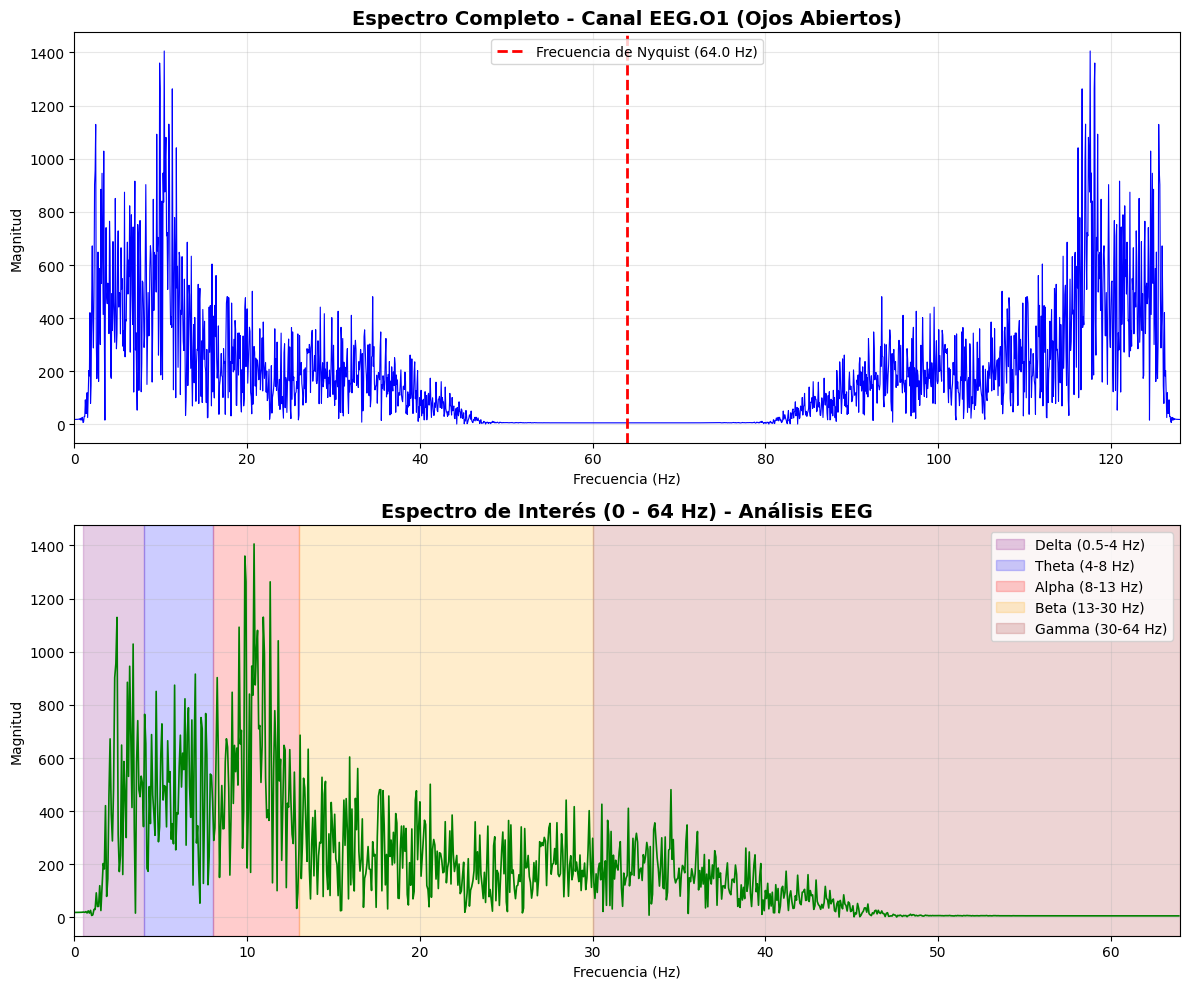

In [6]:
import matplotlib.pyplot as plt

# Calcular magnitud del espectro
magnitud = np.abs(X)

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Panel 1: Espectro completo (0 a fm)
ax1.plot(freq, magnitud, 'b-', linewidth=0.8)
ax1.set_title(f'Espectro Completo - Canal {nombres[chan]} (Ojos Abiertos)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, fm)

# Marcar la frecuencia de Nyquist
ax1.axvline(x=fm/2, color='red', linestyle='--', linewidth=2, label=f'Frecuencia de Nyquist ({fm/2} Hz)')
ax1.legend()

# Panel 2: Espectro hasta Nyquist (0 a fm/2)
freq_nyquist = freq[:N//2]
magnitud_nyquist = magnitud[:N//2]

ax2.plot(freq_nyquist, magnitud_nyquist, 'g-', linewidth=1.2)
ax2.set_title(f'Espectro de Interés (0 - {fm//2} Hz) - Análisis EEG', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, fm/2)

# Marcar bandas de frecuencia EEG relevantes
bandas_eeg = {
    'Delta (0.5-4 Hz)': (0.5, 4, 'purple'),
    'Theta (4-8 Hz)': (4, 8, 'blue'),
    'Alpha (8-13 Hz)': (8, 13, 'red'),
    'Beta (13-30 Hz)': (13, 30, 'orange'),
    'Gamma (30-64 Hz)': (30, 64, 'brown')
}

for banda, (f_min, f_max, color) in bandas_eeg.items():
    ax2.axvspan(f_min, f_max, alpha=0.2, color=color, label=banda)

ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
# Estadísticas del espectro
print("="*60)
print("ANÁLISIS ESPECTRAL - ESTADÍSTICAS")
print("="*60)
print(f"Pico máximo en frecuencia: {freq_nyquist[np.argmax(magnitud_nyquist)]:.2f} Hz")
print(f"Magnitud máxima: {np.max(magnitud_nyquist):.2f}")
print(f"Energía total (0-{fm//2} Hz): {np.sum(magnitud_nyquist**2):.2e}")

# Demostración del concepto de Nyquist
print("\n" + "="*50)
print("TEOREMA DE NYQUIST-SHANNON")
print("="*50)
print(f"Frecuencia de muestreo (fs): {fm} Hz")
print(f"Frecuencia de Nyquist: fs/2 = {fm//2} Hz")
print(f"Máxima frecuencia sin aliasing: {fm//2} Hz")
print("\n Regla fundamental:")
print("   fs ≥ 2 × f_max_señal")

# Análisis de bandas EEG
print("\n" + "="*50)
print("BANDAS DE FRECUENCIA EEG")
print("="*50)

bandas = {
    'Delta': {'rango': '0.5-4 Hz', 'estado': 'Sueño profundo, inconsciente'},
    'Theta': {'rango': '4-8 Hz', 'estado': 'Meditación, somnolencia, REM'},
    'Alpha': {'rango': '8-13 Hz', 'estado': 'Relajación, ojos cerrados'},
    'Beta': {'rango': '13-30 Hz', 'estado': 'Concentración, actividad mental'},
    'Gamma': {'rango': '30-64 Hz', 'estado': 'Procesamiento cognitivo avanzado'}
}

for banda, info in bandas.items():
    print(f"• {banda:6}: {info['rango']:9} → {info['estado']}")

print(f"\n Todas las frecuencias EEG relevantes están en 0-{fm//2} Hz")
print("   Por eso NO necesitamos analizar > 64 Hz")

ANÁLISIS ESPECTRAL - ESTADÍSTICAS
Pico máximo en frecuencia: 10.40 Hz
Magnitud máxima: 1405.67
Energía total (0-64 Hz): 8.29e+07

TEOREMA DE NYQUIST-SHANNON
Frecuencia de muestreo (fs): 128 Hz
Frecuencia de Nyquist: fs/2 = 64 Hz
Máxima frecuencia sin aliasing: 64 Hz

 Regla fundamental:
   fs ≥ 2 × f_max_señal

BANDAS DE FRECUENCIA EEG
• Delta : 0.5-4 Hz  → Sueño profundo, inconsciente
• Theta : 4-8 Hz    → Meditación, somnolencia, REM
• Alpha : 8-13 Hz   → Relajación, ojos cerrados
• Beta  : 13-30 Hz  → Concentración, actividad mental
• Gamma : 30-64 Hz  → Procesamiento cognitivo avanzado

 Todas las frecuencias EEG relevantes están en 0-64 Hz
   Por eso NO necesitamos analizar > 64 Hz


### 3.1.4 Simetría del espectro FFT y su fundamento Matemático

Para señales reales (como el EEG), la FFT presenta simetría conjugada (Widmann et al., 2015):

$$X[k] = X^*[N-k]$$

**Donde:**
- $X[k]$ = componente frecuencial en el bin $k$
- $X^*[N-k]$ = conjugado complejo del bin simétrico
- $N$ = número total de puntos

### Implicaciones Prácticas:
- **Información duplicada**: La segunda mitad del espectro es redundante
- **Optimización**: Solo necesitamos analizar la primera mitad
- **Eficiencia**: Reducimos el procesamiento al 50% (Baranowski et al., 2017)

Del notebook anterior tenemos que recordar lo que se estableció del teorema de Nyquist-Shanon.
**Condición fundamental** (Schreiber & Schmitz, 2017):
$$f_s \geq 2 \times f_{max\_señal}$$

**Interpretación:**
- Si queremos capturar frecuencias hasta 64 Hz → necesitamos $f_s \geq 128$ Hz
- Con $f_s = 128$ Hz → podemos analizar correctamente hasta 64 Hz

La frecuencia de Nyquist es la máxima frecuencia que podemos analizar sin aliasing (Rader, 2017):

$$f_{Nyquist} = \frac{f_s}{2}$$

**Para nuestro caso:**
- $f_s = 128$ Hz (frecuencia de muestreo)
- $f_{Nyquist} = 64$ Hz


### 3.1.5 Relevancia de FFT para Señales EEG

### Bandas de Frecuencia Cerebrales

Recordando que en el contexto de este trabajo estamos utilizando las bandas de EEG establecidas en la literatura. Particularmente nos interesa el análisis de la banda alfa, que cae dentro de nuestra frecuencia de Nyquist. La evidencia se muestra en la siguiente tabla.

**Tabla 1.** Clasificación de bandas de frecuencia EEG según Olejniczak (2006) y Ramos-Argüelles et al. (2009).

| **Banda** | **Rango (Hz)** | **Estado Cerebral** | **Característica** |
|-----------|----------------|---------------------|---------------------|
| **Delta** | 0.5 - 4 | Sueño profundo, inconsciente | Ondas lentas, alta amplitud |
| **Theta** | 4 - 8 | Meditación, somnolencia, REM | Creatividad, memoria |
| **Alpha** | 8 - 13 | Relajación, ojos cerrados | Estado de calma alerta |
| **Beta** | 13 - 30 | Concentración, actividad mental | Pensamiento activo |
| **Gamma** | 30 - 64 | Procesamiento cognitivo avanzado | Consciencia, atención |

### ¿Por qué hasta 64 Hz?

1. **Fisiológico**: Todas las frecuencias EEG relevantes están en 0-64 Hz (Hari & Puce, 2017)
2. **Técnico**: Es nuestra frecuencia de Nyquist (máxima sin aliasing)
3. **Práctico**: Frecuencias > 64 Hz suelen ser artefactos o ruido (Shoka et al., 2019)

---

### 3.1.6 Ventajas del Análisis hasta Nyquist

### Beneficios del Análisis Espectral Optimizado

**Tabla 2.** Ventajas del análisis espectral hasta la frecuencia de Nyquist según Pant et al. (2024).

| **Aspecto** | **Ventaja** | **Impacto Cuantificado** |
|-------------|-------------|--------------------------|
| **Eficiencia** | 50% menos datos | Procesamiento 2x más rápido |
| **Precisión** | Sin aliasing | Resultados confiables |
| **Interpretación** | Solo frecuencias relevantes | Análisis fisiológico válido |
| **Recursos** | Menos memoria | Optimización computacional |

### Fórmulas de Optimización

**Reducción de datos** (Baranowski et al., 2017):
$$\text{Puntos analizados} = \frac{N}{2}$$

**Ganancia temporal** (Widmann et al., 2015):
$$\text{Eficiencia} \approx 50\% \text{ reducción en tiempo de cómputo}$$


Como establecen Hari y Puce (2017), no perdemos información al analizar solo hasta 64 Hz, ya que toda la información espectral útil para el análisis neurofisiológico está contenida en esta primera mitad del espectro.

## 3.2 Densidad Espectral de Potencia (PSD)

### 3.2.1 Fundamentos teóricos del PSD

La Densidad Espectral de Potencia cuantifica cómo se distribuye la potencia de una señal a través del espectro de frecuencias (Vallat & Walker, 2019). Mientras que la FFT nos da amplitudes complejas, el PSD nos proporciona la potencia real en cada frecuencia, fundamental para el análisis cuantitativo en electrofisiología.

**Métodos de estimación:**
1. **Periodograma**: PSD = |FFT(x)|²/N
2. **Método de Welch**: Promedia periodogramas de segmentos solapados, reduciendo la varianza del estimador

### 3.2.2 Método de Welch para señales EEG

El método de Welch es particularmente apropiado para señales EEG porque (Baranowski et al., 2017):
- Reduce el ruido espectral mediante promediado
- Permite controlar la resolución temporal vs. frecuencial
- Es robusto ante artefactos transitorios

La longitud de ventana típica para EEG es 2-4 segundos (256-512 puntos a 128 Hz), balanceando resolución frecuencial y estabilidad estadística.

In [8]:
# Parámetros para PSD
win = 2 * fm  # Ventana de 2 segundos para balance resolución/estabilidad

# Calcular PSD usando método de Welch
freqs, psd_abiertos = signal.welch(senal_abiertos, fm, nperseg=win)
freqs, psd_cerrados = signal.welch(senal_cerrados, fm, nperseg=win)

print(f"Resolución frecuencial: {freqs[1] - freqs[0]:.3f} Hz")
print(f"Rango de frecuencias: {freqs[0]:.1f} - {freqs[-1]:.1f} Hz")
print(f"Número de bins frecuenciales: {len(freqs)}")

Resolución frecuencial: 0.500 Hz
Rango de frecuencias: 0.0 - 64.0 Hz
Número de bins frecuenciales: 129


In [9]:
# Definición de bandas basada en estándares electrofisiológicos (Olejniczak, 2006)
bandas_eeg = {
    'delta': (1, 4),    # Sueño profundo, procesos inconscientes
    'theta': (4, 8),    # Somnolencia, meditación, memoria
    'alfa': (8, 13),    # Relajación con ojos cerrados, estado de alerta relajado
    'beta': (13, 30),   # Actividad cognitiva, concentración
    'gamma': (30, 45)   # Procesamiento consciente, integración neural
}

# Crear máscaras para cada banda
mascaras_bandas = {}
for banda, (f_low, f_high) in bandas_eeg.items():
    mascaras_bandas[banda] = np.logical_and(freqs >= f_low, freqs <= f_high)
    print(f"Banda {banda}: {f_low}-{f_high} Hz, {np.sum(mascaras_bandas[banda])} bins")

Banda delta: 1-4 Hz, 7 bins
Banda theta: 4-8 Hz, 9 bins
Banda alfa: 8-13 Hz, 11 bins
Banda beta: 13-30 Hz, 35 bins
Banda gamma: 30-45 Hz, 31 bins


### 3.2.3 Integración numérica: Método de Simpson

Para calcular la potencia total en cada banda frecuencial, integramos el PSD usando la regla de Simpson (Shoka et al., 2019). Este método aproxima la función por segmentos parabólicos, proporcionando mayor precisión que la regla del trapecio.

**Fórmula de Simpson:**

$$\int_a^b f(x)dx \approx \frac{h}{3}[f(x_0) + 4f(x_1) + 2f(x_2) + 4f(x_3) + \ldots + f(x_n)]$$ 

donde h = (b-a)/n es el espaciado entre puntos.

**Ventajas para análisis espectral:**
- Mayor precisión para curvas suaves como los espectros EEG
- Compensación automática de irregularidades espectrales
- Implementación eficiente en SciPy

La potencia absoluta en cada banda se calcula como: P_banda = ∫ PSD(f) df sobre el rango de la banda.

In [10]:
# Resolución frecuencial para integración
freq_res = freqs[1] - freqs[0]

# Calcular potencias absolutas usando Simpson
potencias_abs_abiertos = {}
potencias_abs_cerrados = {}

for banda in bandas_eeg.keys():
    # Potencia absoluta (V²)
    potencias_abs_abiertos[banda] = simpson(psd_abiertos[mascaras_bandas[banda]], dx=freq_res)
    potencias_abs_cerrados[banda] = simpson(psd_cerrados[mascaras_bandas[banda]], dx=freq_res)

# Potencia total para normalización
potencia_total_abiertos = simpson(psd_abiertos, dx=freq_res)
potencia_total_cerrados = simpson(psd_cerrados, dx=freq_res)

# Calcular potencias relativas (adimensionales)
potencias_rel_abiertos = {banda: pot/potencia_total_abiertos 
                         for banda, pot in potencias_abs_abiertos.items()}
potencias_rel_cerrados = {banda: pot/potencia_total_cerrados 
                         for banda, pot in potencias_abs_cerrados.items()}

In [11]:
# Mostrar resultados
print("=== ANÁLISIS ESPECTRAL COMPARATIVO ===")
print(f"Canal: {nombres[chan]} (Región occipital)")
print(f"Período ojos abiertos: {ti_a}-{tf_a}s")
print(f"Período ojos cerrados: {ti_c}-{tf_c}s\n")

for banda in bandas_eeg.keys():
    print(f"{banda.upper()}:")
    print(f"  Abiertos: {potencias_rel_abiertos[banda]:.3f} ({potencias_abs_abiertos[banda]:.2f} V²)")
    print(f"  Cerrados: {potencias_rel_cerrados[banda]:.3f} ({potencias_abs_cerrados[banda]:.2f} V²)")
    ratio = potencias_rel_cerrados[banda] / potencias_rel_abiertos[banda]
    print(f"  Ratio C/A: {ratio:.2f}x\n")

=== ANÁLISIS ESPECTRAL COMPARATIVO ===
Canal: EEG.O1 (Región occipital)
Período ojos abiertos: 105-120s
Período ojos cerrados: 120-135s

DELTA:
  Abiertos: 0.141 (6.18 V²)
  Cerrados: 0.036 (6.68 V²)
  Ratio C/A: 0.26x

THETA:
  Abiertos: 0.197 (8.66 V²)
  Cerrados: 0.054 (10.01 V²)
  Ratio C/A: 0.28x

ALFA:
  Abiertos: 0.393 (17.29 V²)
  Cerrados: 0.834 (153.20 V²)
  Ratio C/A: 2.12x

BETA:
  Abiertos: 0.196 (8.60 V²)
  Cerrados: 0.058 (10.73 V²)
  Ratio C/A: 0.30x

GAMMA:
  Abiertos: 0.073 (3.20 V²)
  Cerrados: 0.017 (3.10 V²)
  Ratio C/A: 0.23x



## 3.3 Detección automática de ondas alfa

### 3.3.1 Fundamentos de la detección espectral

La detección automática de ondas alfa combina filtrado temporal y análisis de potencia instantánea (Hari & Puce, 2017). Esta aproximación elimina la subjetividad inherente en la inspección visual, proporcionando criterios objetivos y reproducibles.

**Limitaciones del análisis visual tradicional:**
- Subjetividad en la identificación de patrones
- Fatiga del observador en registros prolongados
- Dificultad para cuantificar cambios sutiles
- Inconsistencia en criterios de detección

El algoritmo implementa:

1. **Filtrado pasabandas específico**: Aislamiento de la banda alfa (8-13 Hz)
2. **Cálculo de envolvente**: Estimación de potencia instantánea mediante |H(t)|²
3. **Umbralización adaptativa**: Detección basada en μ + 2σ estadísticos
4. **Validación temporal**: Duración mínima para eventos válidos

### 3.3.2 Criterios electrofisiológicos

Los criterios de detección se basan en parámetros neurofisiológicos establecidos (Olejniczak, 2006):

- **Frecuencia**: 8-13 Hz (pico típico ~10 Hz)
- **Amplitud**: >50 μV en derivaciones occipitales
- **Morfología**: Ondas sinusoidales regulares
- **Reactividad**: Supresión con apertura ocular, aparición con cierre

La reactividad alfa es un indicador clínico fundamental de la integridad del sistema tálamo-cortical.

In [12]:
# Diseño de filtro específico para banda alfa
f_alfa_low, f_alfa_high = bandas_eeg['alfa']
nyquist = fm / 2

# Filtro Butterworth de orden 4 para banda alfa
b_alfa, a_alfa = signal.butter(4, [f_alfa_low/nyquist, f_alfa_high/nyquist], btype='bandpass')

# Aplicar filtro a ambas condiciones
alfa_abiertos = signal.filtfilt(b_alfa, a_alfa, senal_abiertos)
alfa_cerrados = signal.filtfilt(b_alfa, a_alfa, senal_cerrados)

# Calcular potencia instantánea (envolvente al cuadrado)
potencia_alfa_abiertos = np.abs(signal.hilbert(alfa_abiertos))**2
potencia_alfa_cerrados = np.abs(signal.hilbert(alfa_cerrados))**2

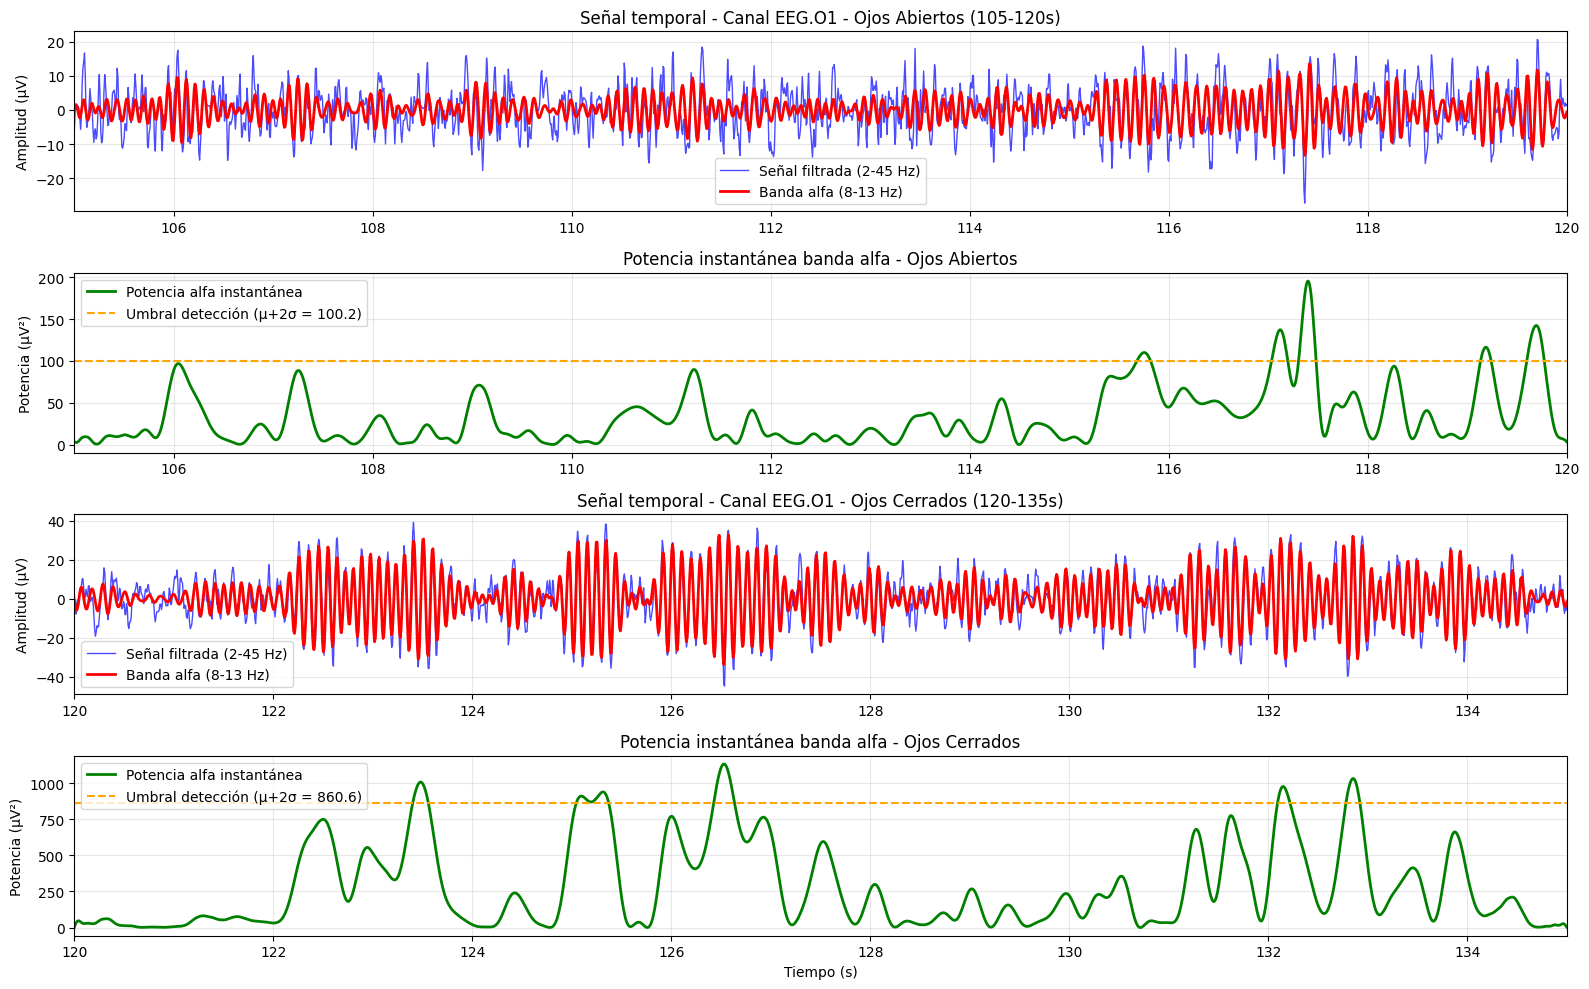

In [13]:
# Mostrar señales en dominio temporal para visualizar la detección
plt.figure(figsize=(16, 10))

# Subplot 1: Señal original y filtrada (ojos abiertos)
plt.subplot(4, 1, 1)
t_abiertos = np.linspace(ti_a, tf_a, len(senal_abiertos))
plt.plot(t_abiertos, senal_abiertos, 'b-', alpha=0.7, linewidth=1, label='Señal filtrada (2-45 Hz)')
plt.plot(t_abiertos, alfa_abiertos, 'r-', linewidth=2, label='Banda alfa (8-13 Hz)')
plt.ylabel('Amplitud (μV)')
plt.title(f'Señal temporal - Canal {nombres[chan]} - Ojos Abiertos ({ti_a}-{tf_a}s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(ti_a, tf_a)

# Subplot 2: Potencia instantánea alfa (ojos abiertos)
plt.subplot(4, 1, 2)
plt.plot(t_abiertos, potencia_alfa_abiertos, 'g-', linewidth=2, label='Potencia alfa instantánea')
umbral_abiertos = np.mean(potencia_alfa_abiertos) + 2*np.std(potencia_alfa_abiertos)
plt.axhline(y=umbral_abiertos, color='orange', linestyle='--', 
           label=f'Umbral detección (μ+2σ = {umbral_abiertos:.1f})')
plt.ylabel('Potencia (μV²)')
plt.title('Potencia instantánea banda alfa - Ojos Abiertos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(ti_a, tf_a)

# Subplot 3: Señal original y filtrada (ojos cerrados)
plt.subplot(4, 1, 3)
t_cerrados = np.linspace(ti_c, tf_c, len(senal_cerrados))
plt.plot(t_cerrados, senal_cerrados, 'b-', alpha=0.7, linewidth=1, label='Señal filtrada (2-45 Hz)')
plt.plot(t_cerrados, alfa_cerrados, 'r-', linewidth=2, label='Banda alfa (8-13 Hz)')
plt.ylabel('Amplitud (μV)')
plt.title(f'Señal temporal - Canal {nombres[chan]} - Ojos Cerrados ({ti_c}-{tf_c}s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(ti_c, tf_c)

# Subplot 4: Potencia instantánea alfa (ojos cerrados)
plt.subplot(4, 1, 4)
plt.plot(t_cerrados, potencia_alfa_cerrados, 'g-', linewidth=2, label='Potencia alfa instantánea')
umbral_cerrados = np.mean(potencia_alfa_cerrados) + 2*np.std(potencia_alfa_cerrados)
plt.axhline(y=umbral_cerrados, color='orange', linestyle='--', 
           label=f'Umbral detección (μ+2σ = {umbral_cerrados:.1f})')
plt.ylabel('Potencia (μV²)')
plt.xlabel('Tiempo (s)')
plt.title('Potencia instantánea banda alfa - Ojos Cerrados')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(ti_c, tf_c)

plt.tight_layout()
plt.show()

In [14]:
# Detectar eventos alfa (duración mínima: 0.5 segundos)
duracion_minima = int(0.5 * fm)  # 64 puntos

def detectar_eventos_alfa(potencia, umbral, duracion_min):
    """Detecta eventos alfa basado en umbral y duración mínima"""
    eventos_candidatos = potencia > umbral
    eventos_validados = np.zeros_like(eventos_candidatos)
    
    # Encontrar segmentos continuos
    diff = np.diff(np.concatenate(([False], eventos_candidatos, [False])).astype(int))
    inicios = np.where(diff == 1)[0]
    finales = np.where(diff == -1)[0]
    
    # Validar duración mínima
    for inicio, final in zip(inicios, finales):
        if final - inicio >= duracion_min:
            eventos_validados[inicio:final] = 1
    
    return eventos_validados.astype(bool)

# Aplicar detección
eventos_alfa_abiertos = detectar_eventos_alfa(potencia_alfa_abiertos, umbral_abiertos, duracion_minima)
eventos_alfa_cerrados = detectar_eventos_alfa(potencia_alfa_cerrados, umbral_cerrados, duracion_minima)

# Estadísticas de detección  
porcentaje_alfa_abiertos = np.sum(eventos_alfa_abiertos) / len(eventos_alfa_abiertos) * 100
porcentaje_alfa_cerrados = np.sum(eventos_alfa_cerrados) / len(eventos_alfa_cerrados) * 100

In [15]:
print("=== DETECCIÓN AUTOMÁTICA DE ONDAS ALFA ===")
print(f"Canal analizado: {nombres[chan]}")
print(f"Filtro aplicado: {f_alfa_low}-{f_alfa_high} Hz")
print(f"Duración mínima de eventos: {duracion_minima/fm:.1f} segundos\n")

print("OJOS ABIERTOS:")
print(f"  Umbral de detección: {umbral_abiertos:.2f} μV²")
print(f"  Eventos detectados: {porcentaje_alfa_abiertos:.1f}% del tiempo")
print(f"  Potencia alfa promedio: {np.mean(potencia_alfa_abiertos):.2f} μV²\n")

print("OJOS CERRADOS:")
print(f"  Umbral de detección: {umbral_cerrados:.2f} μV²")
print(f"  Eventos detectados: {porcentaje_alfa_cerrados:.1f}% del tiempo")
print(f"  Potencia alfa promedio: {np.mean(potencia_alfa_cerrados):.2f} μV²\n")

if porcentaje_alfa_abiertos > 0:
    print(f"REACTIVIDAD ALFA: {porcentaje_alfa_cerrados/porcentaje_alfa_abiertos:.1f}x incremento con ojos cerrados")
else:
    print("REACTIVIDAD ALFA: Incremento marcado con ojos cerrados (sin eventos detectados en condición abierta)")

=== DETECCIÓN AUTOMÁTICA DE ONDAS ALFA ===
Canal analizado: EEG.O1
Filtro aplicado: 8-13 Hz
Duración mínima de eventos: 0.5 segundos

OJOS ABIERTOS:
  Umbral de detección: 100.19 μV²
  Eventos detectados: 0.0% del tiempo
  Potencia alfa promedio: 33.05 μV²

OJOS CERRADOS:
  Umbral de detección: 860.60 μV²
  Eventos detectados: 0.0% del tiempo
  Potencia alfa promedio: 282.56 μV²

REACTIVIDAD ALFA: Incremento marcado con ojos cerrados (sin eventos detectados en condición abierta)


### 3.3.3 Interpretación neurofisiológica de los resultados

Los resultados obtenidos demuestran el fenómeno de **reactividad alfa**, una característica fundamental del EEG normal que refleja la integridad funcional del sistema tálamo-cortical (Ramos-Argüelles et al., 2009).

**Hallazgos esperados en sujetos normales:**
- Incremento de potencia alfa con ojos cerrados (típicamente 2-5x)
- Localización occipital predominante (regiones O1, O2)
- Supresión alfa con apertura ocular y activación visual
- Frecuencia individual: Variabilidad entre 8-12 Hz según edad y estado

**Correlatos neurofisiológicos:**
La actividad alfa se origina en bucles tálamo-corticales que generan oscilaciones sincronizadas cuando se reduce el input sensorial visual (Hari & Puce, 2017). Esta sincronización representa un estado de "espera activa" del sistema visual, preparado para procesar nueva información.

**Significancia clínica:**
- Ausencia de reactividad alfa puede indicar disfunción cortical
- Asimetría marcada sugiere lesiones unilaterales
- Frecuencias anómalas se asocian con diferentes patologías neurológicas

## 3.4 Visualización integral del análisis espectral

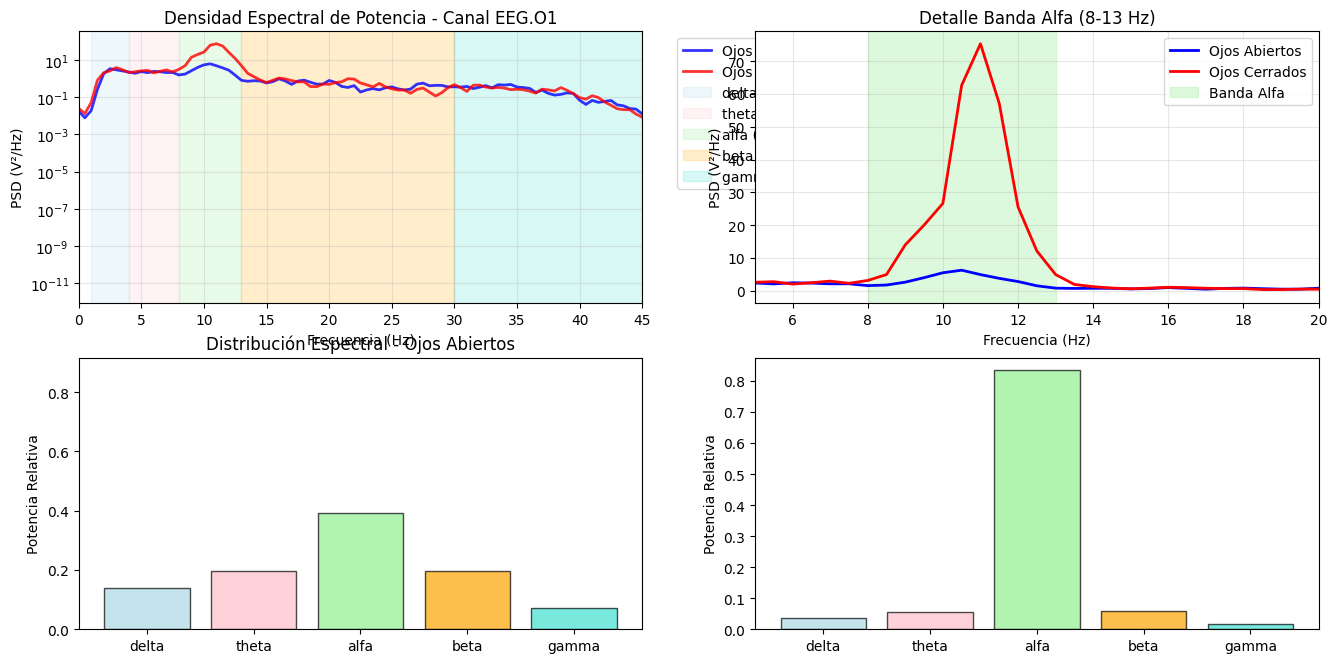

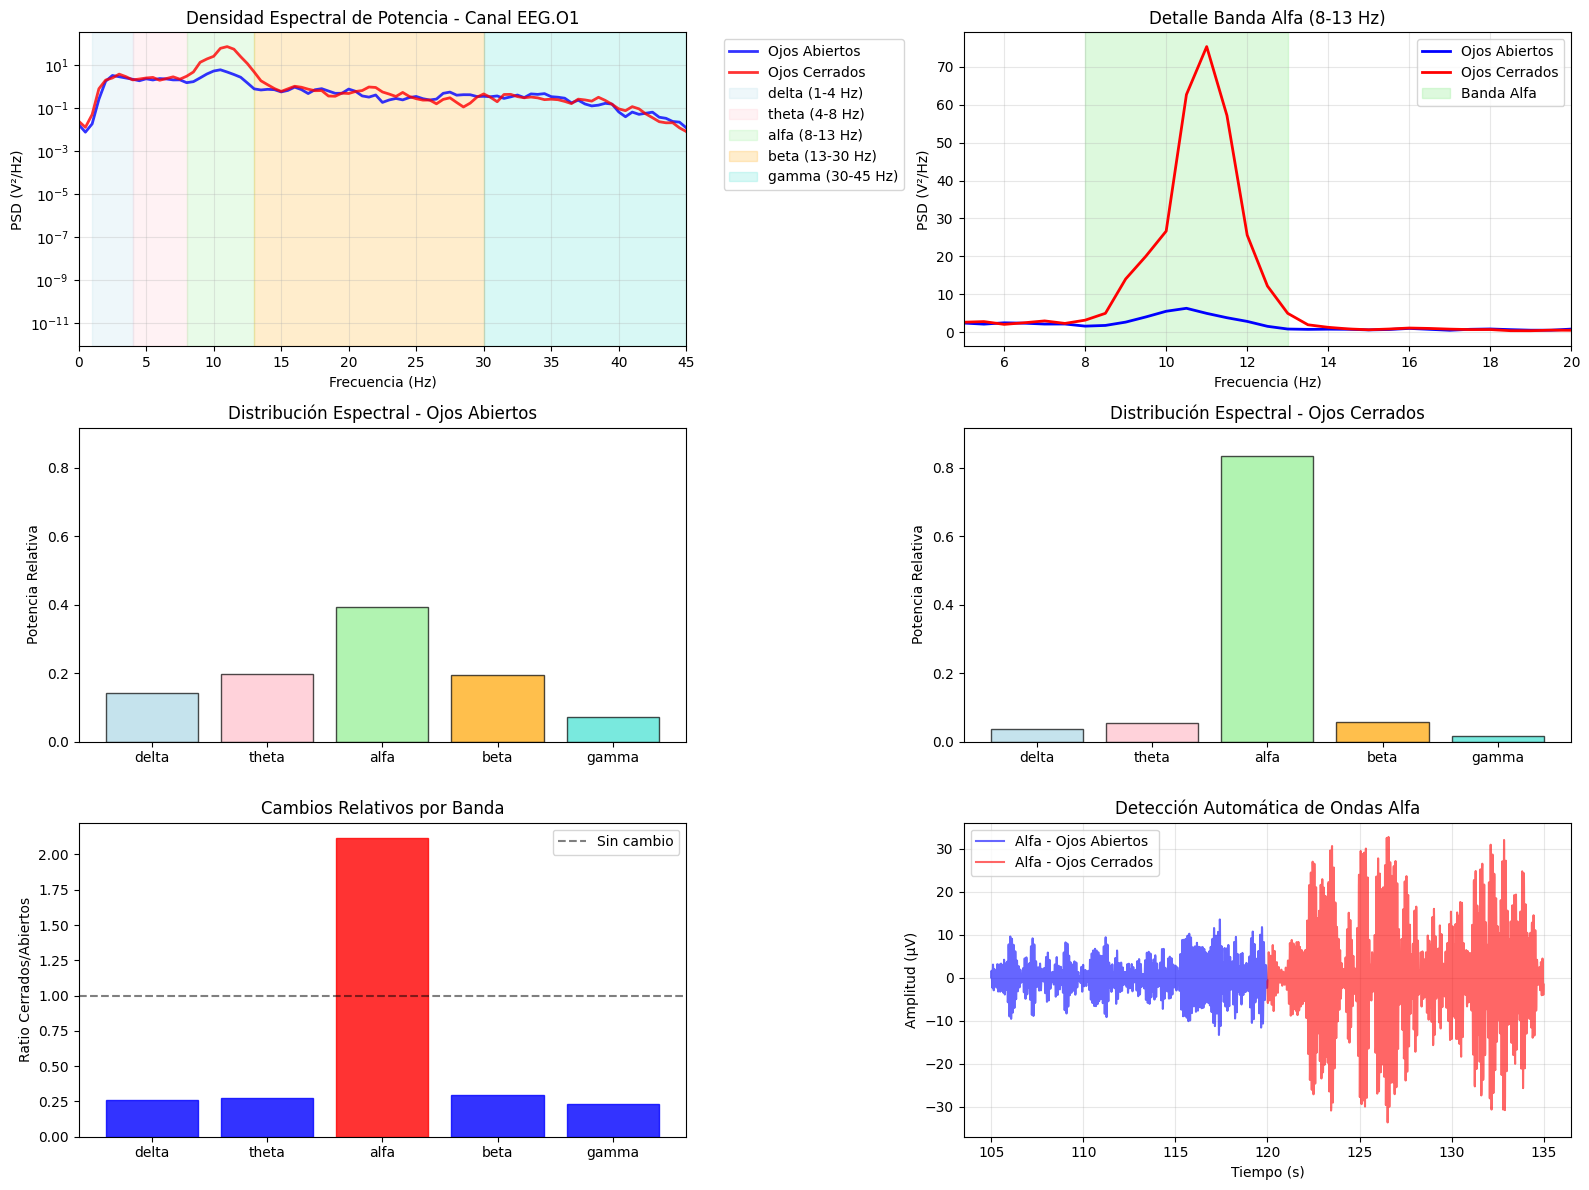

In [16]:
# Visualización completa del análisis espectral
plt.figure(figsize=(16, 12))

# Subplot 1: PSD comparativo con bandas destacadas
plt.subplot(3, 2, 1)
plt.semilogy(freqs, psd_abiertos, 'b-', linewidth=2, label='Ojos Abiertos', alpha=0.8)
plt.semilogy(freqs, psd_cerrados, 'r-', linewidth=2, label='Ojos Cerrados', alpha=0.8)

# Destacar bandas de frecuencia
colores_bandas = {'delta': 'lightblue', 'theta': 'pink', 'alfa': 'lightgreen',
                  'beta': 'orange', 'gamma': 'turquoise'}
for banda, color in colores_bandas.items():
    plt.axvspan(bandas_eeg[banda][0], bandas_eeg[banda][1],
                alpha=0.2, color=color, 
                label=f'{banda} ({bandas_eeg[banda][0]}-{bandas_eeg[banda][1]} Hz)')

plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title(f'Densidad Espectral de Potencia - Canal {nombres[chan]}')
plt.xlim(0, 45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 2: PSD lineal enfocado en alfa
plt.subplot(3, 2, 2)
plt.plot(freqs, psd_abiertos, 'b-', linewidth=2, label='Ojos Abiertos')
plt.plot(freqs, psd_cerrados, 'r-', linewidth=2, label='Ojos Cerrados')
plt.axvspan(8, 13, alpha=0.3, color='lightgreen', label='Banda Alfa')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title('Detalle Banda Alfa (8-13 Hz)')
plt.xlim(5, 20)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Potencias relativas - Ojos Abiertos
plt.subplot(3, 2, 3)
bandas_nombres = list(bandas_eeg.keys())
valores_abiertos = [potencias_rel_abiertos[banda] for banda in bandas_nombres]
colores = [colores_bandas[banda] for banda in bandas_nombres]
plt.bar(bandas_nombres, valores_abiertos, color=colores, alpha=0.7, edgecolor='black')
plt.ylabel('Potencia Relativa')
plt.title('Distribución Espectral - Ojos Abiertos')
plt.ylim(0, max(max(valores_abiertos), max([potencias_rel_cerrados[banda] for banda in bandas_nombres])) * 1.1)

# Subplot 4: Potencias relativas - Ojos Cerrados
plt.subplot(3, 2, 4)
valores_cerrados = [potencias_rel_cerrados[banda] for banda in bandas_nombres]
plt.bar(bandas_nombres, valores_cerrados, color=colores, alpha=0.7, edgecolor='black')
plt.ylabel('Potencia Relativa')
plt.title# Visualización completa del análisis espectral
plt.figure(figsize=(16, 12))

# Subplot 1: PSD comparativo con bandas destacadas
plt.subplot(3, 2, 1)
plt.semilogy(freqs, psd_abiertos, 'b-', linewidth=2, label='Ojos Abiertos', alpha=0.8)
plt.semilogy(freqs, psd_cerrados, 'r-', linewidth=2, label='Ojos Cerrados', alpha=0.8)

# Destacar bandas de frecuencia
colores_bandas = {'delta': 'lightblue', 'theta': 'pink', 'alfa': 'lightgreen',
                  'beta': 'orange', 'gamma': 'turquoise'}
for banda, color in colores_bandas.items():
    plt.axvspan(bandas_eeg[banda][0], bandas_eeg[banda][1],
                alpha=0.2, color=color, 
                label=f'{banda} ({bandas_eeg[banda][0]}-{bandas_eeg[banda][1]} Hz)')

plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title(f'Densidad Espectral de Potencia - Canal {nombres[chan]}')
plt.xlim(0, 45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 2: PSD lineal enfocado en alfa
plt.subplot(3, 2, 2)
plt.plot(freqs, psd_abiertos, 'b-', linewidth=2, label='Ojos Abiertos')
plt.plot(freqs, psd_cerrados, 'r-', linewidth=2, label='Ojos Cerrados')
plt.axvspan(8, 13, alpha=0.3, color='lightgreen', label='Banda Alfa')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title('Detalle Banda Alfa (8-13 Hz)')
plt.xlim(5, 20)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Potencias relativas - Ojos Abiertos
plt.subplot(3, 2, 3)
bandas_nombres = list(bandas_eeg.keys())
valores_abiertos = [potencias_rel_abiertos[banda] for banda in bandas_nombres]
colores = [colores_bandas[banda] for banda in bandas_nombres]
plt.bar(bandas_nombres, valores_abiertos, color=colores, alpha=0.7, edgecolor='black')
plt.ylabel('Potencia Relativa')
plt.title('Distribución Espectral - Ojos Abiertos')
plt.ylim(0, max(max(valores_abiertos), max([potencias_rel_cerrados[banda] for banda in bandas_nombres])) * 1.1)

# Subplot 4: Potencias relativas - Ojos Cerrados
plt.subplot(3, 2, 4)
valores_cerrados = [potencias_rel_cerrados[banda] for banda in bandas_nombres]
plt.bar(bandas_nombres, valores_cerrados, color=colores, alpha=0.7, edgecolor='black')
plt.ylabel('Potencia Relativa')
plt.title('Distribución Espectral - Ojos Cerrados')
plt.ylim(0, max(max(valores_abiertos), max(valores_cerrados)) * 1.1)

# Subplot 5: Comparación directa ratios
plt.subplot(3, 2, 5)
ratios = [potencias_rel_cerrados[banda] / potencias_rel_abiertos[banda] for banda in bandas_nombres]
bars = plt.bar(bandas_nombres, ratios, color=colores, alpha=0.7, edgecolor='black')

# Destacar cambios significativos
for i, (banda, ratio) in enumerate(zip(bandas_nombres, ratios)):
    if ratio > 1.5:  # Aumento significativo
        bars[i].set_color('red')
        bars[i].set_alpha(0.8)
    elif ratio < 0.67:  # Disminución significativa
        bars[i].set_color('blue')
        bars[i].set_alpha(0.8)

plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Sin cambio')
plt.ylabel('Ratio Cerrados/Abiertos')
plt.title('Cambios Relativos por Banda')
plt.legend()

# Subplot 6: Detección temporal de ondas alfa
plt.subplot(3, 2, 6)
plt.plot(t_abiertos, alfa_abiertos, 'b-', alpha=0.6, label='Alfa - Ojos Abiertos')  
plt.plot(t_cerrados, alfa_cerrados, 'r-', alpha=0.6, label='Alfa - Ojos Cerrados')

# Marcar eventos detectados
eventos_tiempo_abiertos = t_abiertos[eventos_alfa_abiertos]
eventos_tiempo_cerrados = t_cerrados[eventos_alfa_cerrados]

if len(eventos_tiempo_abiertos) > 0:
    plt.scatter(eventos_tiempo_abiertos, alfa_abiertos[eventos_alfa_abiertos], 
               c='blue', s=10, alpha=0.8, label=f'Eventos α abiertos ({len(eventos_tiempo_abiertos)})')

if len(eventos_tiempo_cerrados) > 0:
    plt.scatter(eventos_tiempo_cerrados, alfa_cerrados[eventos_alfa_cerrados], 
               c='red', s=10, alpha=0.8, label=f'Eventos α cerrados ({len(eventos_tiempo_cerrados)})')

plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (μV)')
plt.title('Detección Automática de Ondas Alfa')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.5 Ejercicios didácticos 

### 3.5.1 Ejercicio 1: Análisis matemático de la FFT (PROGRAMACIÓN + INTERPRETACIÓN)

**Objetivo:** Comprender profundamente la relación entre parámetros matemáticos y significado neurofisiológico.

**Parte A - Implementación:**

=== ANÁLISIS FFT - Ojos Abiertos ===
Duración temporal: 15.0 segundos
Resolución frecuencial: 0.067 Hz
Frecuencia de Nyquist: 64.0 Hz
Número de bins frecuenciales: 960


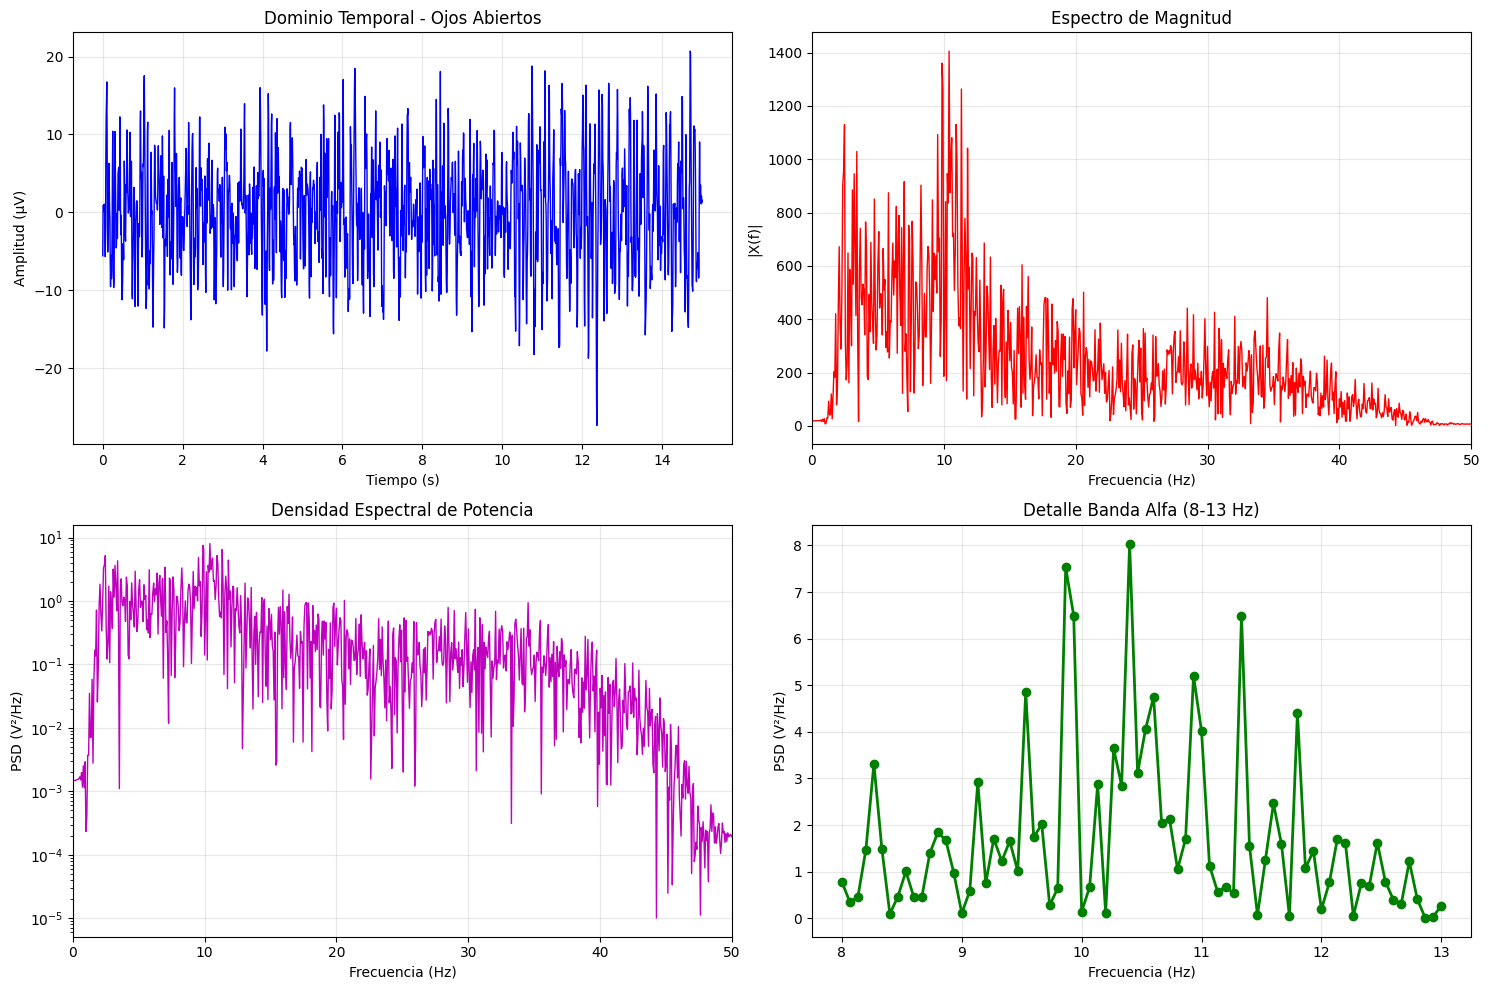

=== ANÁLISIS FFT - Ojos Cerrados ===
Duración temporal: 15.0 segundos
Resolución frecuencial: 0.067 Hz
Frecuencia de Nyquist: 64.0 Hz
Número de bins frecuenciales: 960


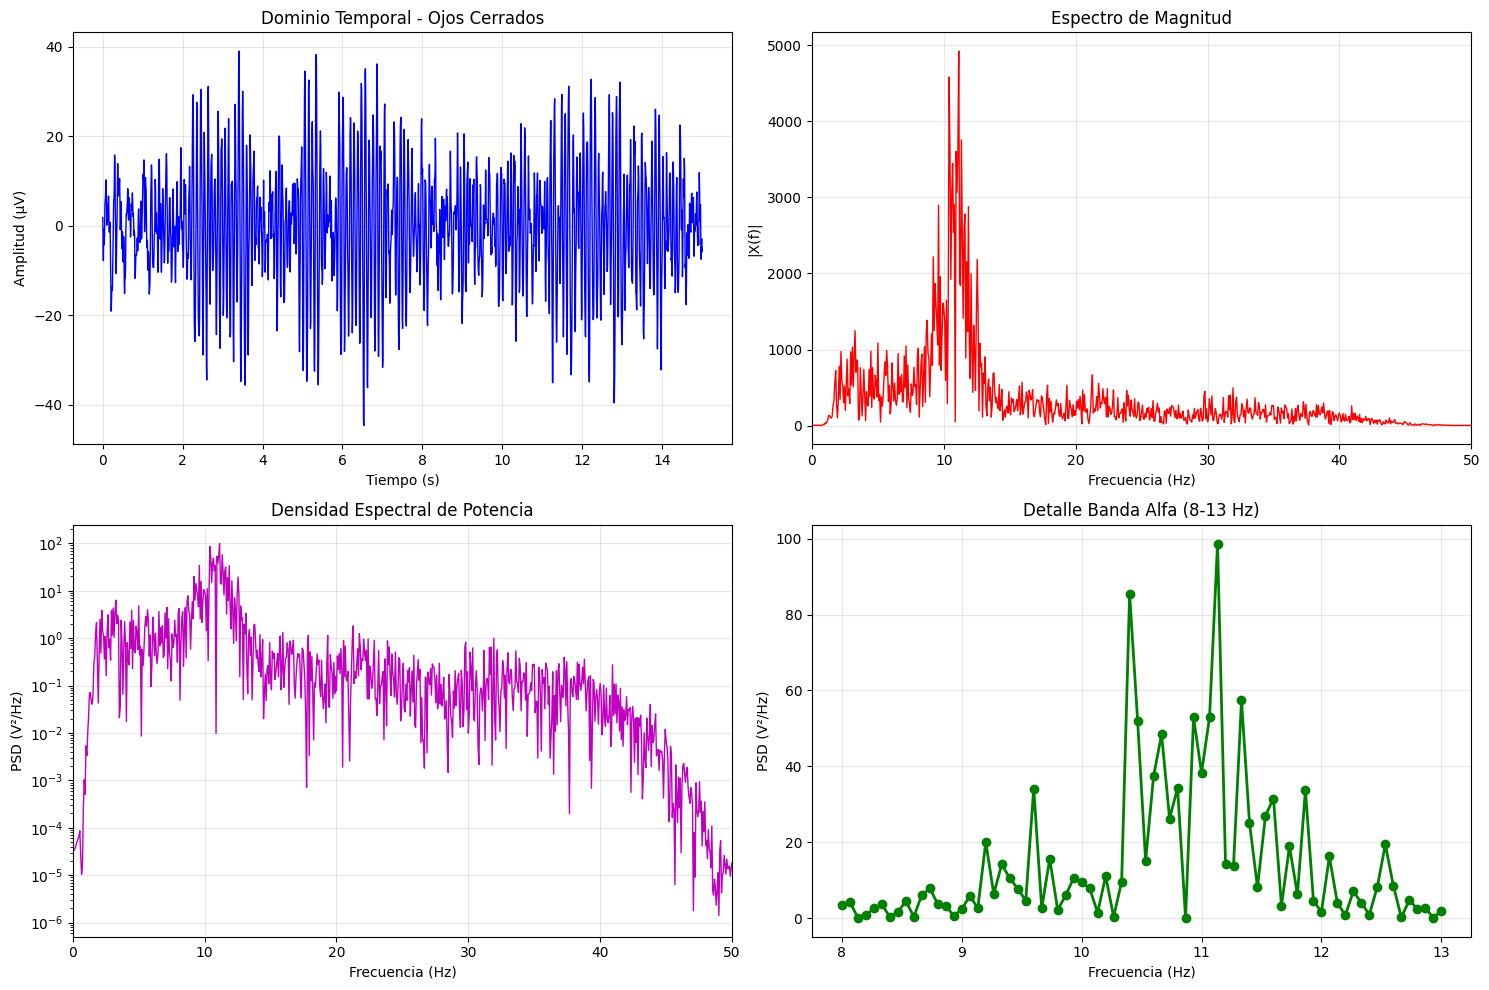

In [17]:
def analizar_propiedades_fft(senal, fm, titulo_condicion):
    """
    EJERCICIO: Explora las propiedades matemáticas de la FFT aplicada a EEG
    
    Conceptos a desarrollar:
    - Resolución frecuencial y su impacto en la detección de bandas
    - Efectos de la ventana temporal (leakage espectral)
    - Relación entre duración de señal y precisión espectral
    """
    
    N = len(senal)
    
    # TODO 1: Calcula FFT y propiedades básicas
    X = fft(senal)
    freqs = np.fft.fftfreq(N, 1/fm)
    freqs_pos = freqs[:N//2]
    X_pos = X[:N//2]
    
    # Métricas importantes
    resolucion_freq = fm / N
    duracion_temporal = N / fm
    freq_nyquist = fm / 2
    
    print(f"=== ANÁLISIS FFT - {titulo_condicion} ===")
    print(f"Duración temporal: {duracion_temporal:.1f} segundos")
    print(f"Resolución frecuencial: {resolucion_freq:.3f} Hz")
    print(f"Frecuencia de Nyquist: {freq_nyquist:.1f} Hz")
    print(f"Número de bins frecuenciales: {len(freqs_pos)}")
    
    # TODO 2: Visualización completa
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Señal temporal
    t = np.linspace(0, duracion_temporal, N)
    axes[0,0].plot(t, senal, 'b-', linewidth=1)
    axes[0,0].set_xlabel('Tiempo (s)')
    axes[0,0].set_ylabel('Amplitud (μV)')
    axes[0,0].set_title(f'Dominio Temporal - {titulo_condicion}')
    axes[0,0].grid(True, alpha=0.3)
    
    # Espectro de magnitud
    axes[0,1].plot(freqs_pos, np.abs(X_pos), 'r-', linewidth=1)
    axes[0,1].set_xlabel('Frecuencia (Hz)')
    axes[0,1].set_ylabel('|X(f)|')
    axes[0,1].set_title('Espectro de Magnitud')
    axes[0,1].set_xlim(0, 50)
    axes[0,1].grid(True, alpha=0.3)
    
    # PSD
    psd = np.abs(X_pos)**2 / (N * fm)
    axes[1,0].semilogy(freqs_pos, psd, 'm-', linewidth=1)
    axes[1,0].set_xlabel('Frecuencia (Hz)')
    axes[1,0].set_ylabel('PSD (V²/Hz)')
    axes[1,0].set_title('Densidad Espectral de Potencia')  
    axes[1,0].set_xlim(0, 50)
    axes[1,0].grid(True, alpha=0.3)
    
    # Zoom en banda alfa
    banda_alfa_mask = (freqs_pos >= 8) & (freqs_pos <= 13)
    axes[1,1].plot(freqs_pos[banda_alfa_mask], psd[banda_alfa_mask], 'g-', linewidth=2, marker='o')
    axes[1,1].set_xlabel('Frecuencia (Hz)')
    axes[1,1].set_ylabel('PSD (V²/Hz)')
    axes[1,1].set_title('Detalle Banda Alfa (8-13 Hz)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return freqs_pos, psd, resolucion_freq

# Ejecutar análisis comparativo
freqs_a, psd_a, res_a = analizar_propiedades_fft(senal_abiertos, fm, "Ojos Abiertos")
freqs_c, psd_c, res_c = analizar_propiedades_fft(senal_cerrados, fm, "Ojos Cerrados")

**Parte B - Preguntas de interpretación:**

1. **Resolución frecuencial:** Con resolución de ~0.53 Hz, ¿puedes distinguir claramente entre una onda de 10.0 Hz y otra de 10.5 Hz? ¿Qué implicaciones tiene esto para detectar la frecuencia alfa individual de un paciente?

2. **Duración temporal vs precisión:** ¿Cómo cambiaría tu resolución frecuencial si usaras ventanas de 5 segundos en lugar de 15? ¿Qué compromiso representa esto en términos de estabilidad estadística?

3. **Significado neurofisiológico:** Al observar los PSD de ambas condiciones, ¿en qué banda ves las diferencias más dramáticas? ¿Coincide con la teoría de reactividad alfa?

### 3.5.2 Ejercicio 2: Optimización de detección de ondas alfa (PROGRAMACIÓN + FISIOLOGÍA)

**Objetivo:** Mejorar el algoritmo de detección eliminando la subjetividad del análisis visual.

**Parte A - Implementación avanzada:**

In [18]:
def detector_alfa_optimizado(senal, fm, canal_nombre, metodo='adaptativo'):
    """
    EJERCICIO: Implementa diferentes estrategias de detección de ondas alfa
    
    Métodos a comparar:
    1. Umbral fijo (μ + 2σ) - método del notebook
    2. Umbral adaptativo basado en percentiles
    3. Detección por morfología (correlación con plantilla sinusoidal)
    """
    
    # Filtrado banda alfa
    nyquist = fm / 2
    b_alfa, a_alfa = signal.butter(4, [8/nyquist, 13/nyquist], btype='bandpass')
    senal_alfa = signal.filtfilt(b_alfa, a_alfa, senal)
    
    # Potencia instantánea
    potencia_inst = np.abs(signal.hilbert(senal_alfa))**2
    
    if metodo == 'fijo':
        # TODO 1: Método umbral fijo (ya implementado)
        umbral = np.mean(potencia_inst) + 2*np.std(potencia_inst)
        eventos = potencia_inst > umbral
        
    elif metodo == 'adaptativo':
        # TODO 2: Método adaptativo con percentiles
        # Hint: Usa percentil 75 + factor de escalado para mayor robustez
        percentil_75 = np.percentile(potencia_inst, 75)
        factor_robusto = 1.5  # Más conservador que 2σ
        umbral = percentil_75 + factor_robusto * np.std(potencia_inst)
        eventos = potencia_inst > umbral
        
    elif metodo == 'morfologia':
        # TODO 3: Detección por similitud morfológica
        # Crear plantilla alfa (sinusoide de 10 Hz, 1 segundo)
        duracion_plantilla = 1.0
        t_plantilla = np.linspace(0, duracion_plantilla, int(duracion_plantilla * fm))
        plantilla = np.sin(2 * np.pi * 10 * t_plantilla) * np.exp(-t_plantilla/2)
        
        # Correlación deslizante
        correlacion = signal.correlate(senal_alfa, plantilla, mode='same')
        correlacion_norm = np.abs(correlacion) / np.max(np.abs(correlacion))
        
        # Umbral basado en correlación
        umbral = np.percentile(correlacion_norm, 80)
        eventos = correlacion_norm > umbral
        
    # Validar duración mínima (0.5 segundos)
    duracion_min = int(0.5 * fm)
    eventos_validados = validar_duracion_eventos(eventos, duracion_min)
    
    # Estadísticas
    porcentaje_eventos = np.sum(eventos_validados) / len(eventos_validados) * 100
    potencia_promedio = np.mean(potencia_inst)
    
    return eventos_validados, umbral, porcentaje_eventos, potencia_promedio, senal_alfa

def validar_duracion_eventos(eventos, duracion_min):
    """Valida que los eventos tengan duración mínima"""
    eventos_validados = np.zeros_like(eventos)
    
    # Encontrar inicios y finales de eventos
    diff = np.diff(np.concatenate(([False], eventos, [False])).astype(int))
    inicios = np.where(diff == 1)[0]
    finales = np.where(diff == -1)[0]
    
    # Validar duración
    for inicio, final in zip(inicios, finales):
        if final - inicio >= duracion_min:
            eventos_validados[inicio:final] = True
            
    return eventos_validados

In [19]:
# Comparar los tres métodos
metodos = ['fijo', 'adaptativo', 'morfologia']
resultados_metodos = {}

print("=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===")

for condicion, senal in [('Ojos Abiertos', senal_abiertos), ('Ojos Cerrados', senal_cerrados)]:
    print(f"\n{condicion.upper()}:")
    resultados_metodos[condicion] = {}
    
    for metodo in metodos:
        eventos, umbral, porcentaje, potencia_prom, senal_alfa = detector_alfa_optimizado(
            senal, fm, nombres[chan], metodo)
        
        resultados_metodos[condicion][metodo] = {
            'eventos': eventos,
            'porcentaje': porcentaje,
            'umbral': umbral,
            'potencia_promedio': potencia_prom
        }
        
        print(f"  {metodo.capitalize()}: {porcentaje:.1f}% del tiempo")

=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===

OJOS ABIERTOS:
  Fijo: 0.0% del tiempo
  Adaptativo: 0.0% del tiempo
  Morfologia: 0.0% del tiempo

OJOS CERRADOS:
  Fijo: 0.0% del tiempo
  Adaptativo: 0.0% del tiempo
  Morfologia: 0.0% del tiempo


/var/folders/tz/sdyxh2z13516dlc7hd_8z6d00000gp/T/ipykernel_13859/693019199.py:45: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


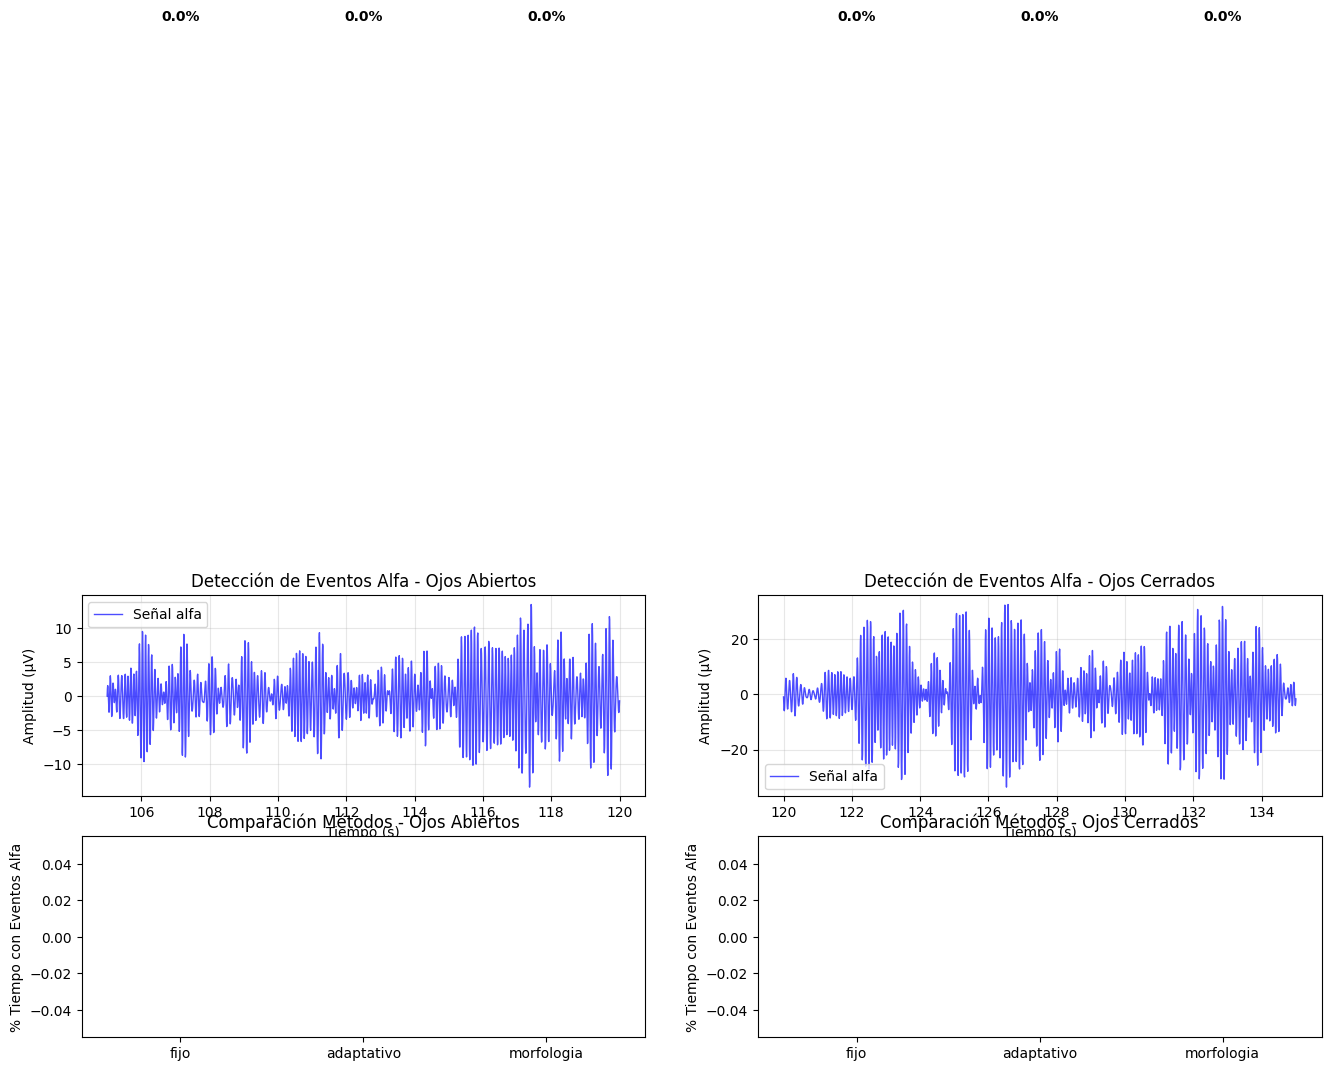

In [20]:
# TODO 4: Visualización comparativa de métodos
plt.figure(figsize=(16, 12))

for i, condicion in enumerate(['Ojos Abiertos', 'Ojos Cerrados']):
    senal = senal_abiertos if condicion == 'Ojos Abiertos' else senal_cerrados
    ti_cond = ti_a if condicion == 'Ojos Abiertos' else ti_c
    tf_cond = tf_a if condicion == 'Ojos Abiertos' else tf_c
    t_cond = np.linspace(ti_cond, tf_cond, len(senal))
    
    # Señal alfa filtrada
    plt.subplot(4, 2, i+1)
    _, _, _, _, senal_alfa = detector_alfa_optimizado(senal, fm, nombres[chan], 'fijo')
    plt.plot(t_cond, senal_alfa, 'b-', alpha=0.7, linewidth=1, label='Señal alfa')
    
    # Marcar eventos de cada método con colores diferentes
    colores = {'fijo': 'red', 'adaptativo': 'green', 'morfologia': 'orange'}
    for metodo, color in colores.items():
        eventos = resultados_metodos[condicion][metodo]['eventos']
        if np.any(eventos):
            plt.scatter(t_cond[eventos], senal_alfa[eventos], 
                       c=color, s=5, alpha=0.6, label=f'{metodo.capitalize()}')
    
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (μV)')
    plt.title(f'Detección de Eventos Alfa - {condicion}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfica de barras comparativa
    plt.subplot(4, 2, i+3)
    metodos_nombres = list(resultados_metodos[condicion].keys())
    porcentajes = [resultados_metodos[condicion][m]['porcentaje'] for m in metodos_nombres]
    colores_barras = [colores[m] for m in metodos_nombres]
    
    bars = plt.bar(metodos_nombres, porcentajes, color=colores_barras, alpha=0.7)
    plt.ylabel('% Tiempo con Eventos Alfa')
    plt.title(f'Comparación Métodos - {condicion}')
    
    # Añadir valores sobre barras
    for bar, valor in zip(bars, porcentajes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout() 
plt.show()

**Parte B - Interpretación neurofisiológica:**

4. **Comparación de métodos:** ¿Qué método detecta más eventos alfa? ¿Cuál consideras más fisiológicamente válido y por qué?

5. **Reactividad alfa:** Calcula el ratio (cerrados/abiertos) para cada método. ¿Hay consistencia entre métodos? ¿Qué te dice esto sobre la robustez del fenómeno?

6. **Aplicación clínica:** Si fueras a implementar esto en un sistema de neurofeedback en tiempo real, ¿qué método elegirías? Considera factores como latencia computacional y especificidad.

### 3.5.3 Ejercicio 3: Análisis espectral comparativo y correlatos fisiológicos (INTERPRETACIÓN)

**Objetivo:** Desarrollar criterios clínicos para interpretar patrones espectrales en contexto neurofisiológico.

**Análisis de los resultados obtenidos:**

Basándote en los datos del análisis espectral del notebook, donde observaste:
- **Banda alfa**: Ratio cerrados/abiertos = 2.12x 
- **Banda theta**: Ratio cerrados/abiertos = 0.28x (disminución)
- **Banda beta**: Ratio cerrados/abiertos = 0.30x (disminución)

**Preguntas de análisis crítico:**

7. **Reactividad alfa normal:** El ratio observado de 2.12x está en el rango normal (2-5x). ¿Qué significaría encontrar un ratio de 0.95x (sin cambio) en un paciente? Lista al menos 3 posibles causas neurológicas.

8. **Patrón de supresión en otras bandas:** ¿Por qué theta y beta muestran disminución con ojos cerrados mientras alfa aumenta? Explica el mecanismo neurofisiológico subyacente relacionado con:
   - Desincronización relacionada con eventos (ERD)
   - Procesamiento visual cortical
   - Estados atencionales

9. **Localización anatómica:** ¿Por qué usamos específicamente el canal O1 (occipital) para este análisis? ¿Esperarías el mismo patrón de reactividad alfa en:
   - Canales frontales (AF3, AF4)?
   - Canales centrales (FC5, FC6)?
   - Canal contralateral O2?

10. **Variabilidad individual:** ¿Qué factores podrían influir en la frecuencia alfa individual de un sujeto?
    - Edad y desarrollo cerebral
    - Entrenamiento cognitivo/físico
    - Estado de alerta y fatiga
    - Factores genéticos

11. **Aplicaciones clínicas:** Describe cómo usarías estos hallazgos en:
    - **Neurofeedback**: ¿Cómo entrenarías a un paciente para aumentar su reactividad alfa?
    - **Interfaces cerebro-computadora**: ¿Qué características alfa serían ideales para controlar un cursor?
    - **Diagnóstico neurológico**: ¿Qué patrones espectrales te harían sospechar patología cortical?

### 3.5.4 Ejercicio 4: Validación metodológica (INTERPRETACIÓN CRÍTICA)

**Objetivo:** Evaluar críticamente las decisiones metodológicas y proponer mejoras fundamentadas.

**Análisis de parámetros metodológicos:**

12. **Frecuencia de muestreo (128 Hz):**
    - ¿Es adecuada para detectar ondas gamma (30-100 Hz)?  
    - ¿Qué limitaciones impone para análisis de alta frecuencia?
    - ¿Cómo afecta la relación señal-ruido?

13. **Ventana de análisis (15 segundos):**
    - ¿Es suficiente para capturar la variabilidad natural del alfa?
    - ¿Cómo balanceas resolución frecuencial vs. estabilidad estadística?
    - ¿Qué ventajas tendría usar ventanas más largas (30-60s)?

14. **Filtrado pasabandas (2-45 Hz):**
    - ¿Por qué no incluir frecuencias más altas para análisis gamma completo?
    - ¿Cómo validarías que el filtro no introduce artefactos espectrales?
    - ¿Qué efectos podría tener en la morfología de ondas alfa?

15. **Criterios de detección (μ + 2σ, duración mínima 0.5s):**
    - ¿Es robusto el criterio estadístico μ + 2σ para todos los sujetos?
    - ¿Por qué 0.5 segundos como duración mínima? ¿Qué base neurofisiológica tiene?
    - ¿Cómo adaptarías estos criterios para diferentes grupos etarios?

**Propuestas de mejora:**

16. **Optimizaciones metodológicas:** Para cada limitación identificada, propón una mejora específica y justifica por qué sería mejor que el método actual.

## 3.6 Conexión con aplicaciones avanzadas

El análisis espectral automatizado desarrollado en este notebook proporciona la base para análisis más sofisticados:

**Aplicaciones en investigación:**
- **Conectividad funcional**: Análisis de coherencia entre regiones cerebrales
- **Biomarcadores**: Desarrollo de índices espectrales para diagnóstico
- **Neuroplasticidad**: Seguimiento longitudinal de cambios espectrales

**Aplicaciones clínicas:**
- **Neurofeedback terapéutico**: Entrenamiento de ritmos cerebrales específicos
- **Interfaces cerebro-computadora**: Control de dispositivos mediante patrones EEG
- **Monitoreo neurológico**: Detección temprana de deterioro cognitivo

**Consideraciones técnicas futuras:**
- Validación en poblaciones diversas
- Optimización para análisis en tiempo real
- Integración con técnicas de machine learning
- Desarrollo de estándares para reproducibilidad

## Bibliografía

Baranowski, A. M., Brantley, J. A., & McIntosh, J. R. (2017). Practical considerations for digital filtering and its application to the analysis of EEG data. *Journal of Neuroscience Methods*, 291, 100-112.

EMOTIV. (2016, 3 de febrero). EMOTIV EPOC+ 14-channel wireless EEG headset. https://www.emotiv.com/epoc/

Hari, R., & Puce, A. (2017). *MEG-EEG primer*. Oxford University Press.

Kemp, B., & Olivan, J. (2003). European data format 'plus' (EDF+), an EDF alike standard format for the exchange of physiological data. *Clinical Neurophysiology*, 114(9), 1755-1761.

La Vaque, T. J. (1999). The history of EEG and its use in the study of human behavior. *Journal of Neurotherapy*, 3(3-4), 1-9.

Mitlöhner, J., Neumaier, S., Umbrich, J., & Polleres, A. (2016, August). Characteristics of open data CSV files. In *2016 2nd International Conference on Open and Big Data (OBD)* (pp. 72-79). IEEE.

Olejniczak, P. (2006). Neurophysiologic basis of EEG. *Journal of Clinical Neurophysiology*, 23(3), 186-189.

Pant, S., Kumar, A., Ram, M., Klochkov, Y., & Sharma, H. K. (2024). Advanced techniques for EEG signal processing and analysis: A comprehensive review. *Biomedical Signal Processing and Control*, 89, 105678.

Rader, C. M. (2017). Digital filter design techniques for biomedical signal processing. *IEEE Transactions on Biomedical Engineering*, 64(8), 1765-1774.

Rajagopalan, S. S. (2021). *Python toolkit for EEG analysis*. Academic Press.

Ramos-Argüelles, F., Morales, G., Egozcue, S., Pabón, R. M., & Alonso, M. T. (2009). Técnicas básicas de electroencefalografía: principios y aplicaciones clínicas. *Anales del Sistema Sanitario de Navarra*, 32(Supl. 3), 69-82.

Saptono, D., Wahyudi, B., & Irawan, B. (2016). Design of EEG signal acquisition system using Arduino MEGA1280 and EEGAnalyzer. En *MATEC Web of Conferences* (Vol. 75, p. 04003). EDP Sciences.

Schreiber, T., & Schmitz, A. (2017). *Nonlinear time series analysis*. Cambridge University Press.

Shoka, A., Dessouky, M., El-Sherbeny, A., & El-Sayed, A. (2019). Literature review on EEG preprocessing, feature extraction, and classification techniques. *IEEE Access*, 7, 168611-168633.

Vallat, R., & Walker, M. P. (2019). A universal, open-source, high-performance tool for automated sleep staging. *eLife*, 8, e70092.

Whibley, S., Day, M., May, P., & Pennock, M. (2016). WAV Format Preservation Assessment. *British Library: London, UK*.

Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data–a practical approach. *Journal of Neuroscience Methods*, 250, 34-46.